In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks - Sgroup/Transfer Learning/Flowers Classification

/content/drive/MyDrive/Colab Notebooks - Sgroup/Transfer Learning/Flowers Classification


In [3]:
import torch
import scipy.io
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from torch.utils.data import random_split
import random
! pip install timm
import timm
from torchsummary import summary
from sklearn import preprocessing

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 26.2 MB/s 


Kiểm tra số lượng label cho từng loài (category)

In [4]:
labels = scipy.io.loadmat('imagelabels.mat')['labels']
dic = {}
for i in labels[0]:
    if i not in dic:
        dic[i] = 1
    else:
        dic[i] += 1
print(dic)
print(sum(list(dic.values())))

{77: 251, 73: 194, 88: 154, 89: 184, 81: 166, 46: 196, 74: 171, 51: 258, 44: 93, 82: 112, 83: 131, 78: 137, 80: 105, 75: 120, 41: 127, 43: 130, 76: 107, 84: 86, 58: 114, 56: 109, 86: 58, 60: 109, 92: 66, 11: 87, 65: 102, 8: 85, 23: 91, 30: 85, 72: 96, 53: 93, 37: 108, 17: 85, 12: 87, 29: 78, 52: 85, 18: 82, 36: 75, 90: 82, 71: 78, 40: 67, 48: 71, 55: 71, 85: 63, 91: 76, 20: 56, 47: 67, 59: 67, 2: 60, 5: 65, 28: 66, 70: 62, 22: 59, 54: 61, 87: 63, 66: 61, 32: 45, 4: 56, 42: 59, 13: 49, 38: 56, 63: 54, 68: 54, 69: 54, 93: 46, 14: 48, 64: 52, 19: 49, 49: 49, 61: 50, 50: 92, 15: 49, 9: 46, 33: 46, 26: 41, 25: 41, 3: 40, 16: 41, 79: 41, 1: 40, 21: 40, 24: 42, 27: 40, 31: 52, 34: 40, 35: 43, 39: 41, 67: 42, 10: 45, 45: 40, 6: 45, 7: 40, 57: 67, 62: 55, 94: 162, 95: 128, 96: 91, 97: 66, 98: 82, 99: 63, 100: 49, 101: 58, 102: 48}
8189


In [5]:
setid = scipy.io.loadmat('setid.mat')
train = setid['trnid']
val = setid['valid']
test = setid['tstid']
print("Train: ", train.shape[-1])
print("Val: ", val.shape[-1])
print("Test: ", test.shape[-1])
print(sum([train.shape[-1], val.shape[-1], test.shape[-1]]))

Train:  1020
Val:  1020
Test:  6149
8189


In [6]:
class CFG:
    num_epochs = 100
    batch_size = 16
    valid_length = 40
    img_path = 'images/jpg'
    folder_path = 'data_folders'
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    size = 224
    learning_rate = 3e-4
    le = preprocessing.LabelEncoder()

In [ ]:
# Không chạy nữa
#shutil.unpack_archive("102flowers.tgz", "images")

In [ ]:
# Không chạy nữa
#f = os.listdir('images/jpg')
#print(len(f))

In [ ]:
# Không chạy nữa
'''
def img_to_folder(img_path=CFG.img_path, fdpath=CFG.folder_path): # Chia images vào từng folder ứng với tên label.

    # Tạo folders có tên ứng với labels.
    for idx in set(labels[0]):
        folder_name = os.path.join(fdpath, str(idx))
        isExist = os.path.exists(folder_name)
        if not isExist:
            os.makedirs(folder_name)

    # Chia images vào từng folder
    for i in range(len(labels[0])):
        shutil.move(os.path.join(img_path, "image_"+str(i+1).zfill(5)+".jpg"), os.path.join(fdpath, str(labels[0][i]))) 

img_to_folder()
'''

'\ndef img_to_folder(img_path=CFG.img_path, fdpath=CFG.folder_path): # Chia images vào từng folder ứng với tên label.\n\n    # Tạo folders có tên ứng với labels.\n    for idx in set(labels[0]):\n        folder_name = os.path.join(fdpath, str(idx))\n        isExist = os.path.exists(folder_name)\n        if not isExist:\n            os.makedirs(folder_name)\n\n    # Chia images vào từng folder\n    for i in range(len(labels[0])):\n        shutil.move(os.path.join(img_path, "image_"+str(i+1).zfill(5)+".jpg"), os.path.join(fdpath, str(labels[0][i]))) \n\nimg_to_folder()\n'

In [7]:
def random_split_dataset(path=CFG.folder_path): # Chia dữ liệu thành 3 tập train, val, test.
    random.seed(42)
    folders = os.listdir(path)
    valid_folders = [folder for folder in folders if len(os.listdir(os.path.join(path, folder))) >= CFG.valid_length]
    CFG.num_classes = len(valid_folders)
    data = []
    CFG.le.fit(valid_folders)
    CFG.le_name_mapping = dict(zip(CFG.le.classes_, CFG.le.transform(CFG.le.classes_)))
    for folder in valid_folders:
        for image_filename in os.listdir(os.path.join(path, folder)):
            data.append((image_filename, folder))
    print('num_classes', CFG.num_classes, 'length dataset', len(data))
    CFG.train_size = int(0.8*len(data))
    CFG.valid_size = int(0.1*len(data))
    CFG.test_size = len(data) - CFG.train_size - CFG.valid_size
    random.shuffle(data)
    return data[ : CFG.train_size], data[CFG.train_size : CFG.train_size + CFG.valid_size], data[CFG.train_size + CFG.valid_size : ]
print(random_split_dataset())

num_classes 102 length dataset 8189
([('image_03774.jpg', '37'), ('image_07369.jpg', '94'), ('image_02172.jpg', '75'), ('image_03730.jpg', '53'), ('image_01001.jpg', '46'), ('image_00824.jpg', '81'), ('image_04720.jpg', '55'), ('image_02495.jpg', '76'), ('image_00096.jpg', '77'), ('image_03798.jpg', '37'), ('image_00098.jpg', '77'), ('image_05682.jpg', '4'), ('image_07011.jpg', '39'), ('image_07176.jpg', '6'), ('image_04243.jpg', '52'), ('image_00317.jpg', '73'), ('image_06299.jpg', '50'), ('image_01978.jpg', '80'), ('image_04435.jpg', '90'), ('image_04281.jpg', '18'), ('image_07358.jpg', '94'), ('image_00509.jpg', '88'), ('image_07346.jpg', '94'), ('image_06635.jpg', '3'), ('image_00953.jpg', '46'), ('image_03655.jpg', '53'), ('image_00083.jpg', '77'), ('image_01630.jpg', '82'), ('image_02139.jpg', '75'), ('image_05115.jpg', '2'), ('image_06115.jpg', '64'), ('image_06505.jpg', '26'), ('image_03986.jpg', '51'), ('image_03654.jpg', '53'), ('image_04150.jpg', '29'), ('image_06383.jpg', '

In [8]:
def get_transforms(transforms_type):
    if transforms_type == 'train':
        return transforms.Compose([
                transforms.Resize((CFG.size, CFG.size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(30),
                transforms.ToTensor(),
                transforms.Normalize(mean=CFG.mean,std=CFG.std)
            ])
    else:
        return transforms.Compose([
            transforms.Resize((CFG.size, CFG.size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=CFG.mean,std=CFG.std)
        ])

In [9]:
class CustomDataset(Dataset):
    def __init__(self,data,transforms_type = 'train'):
        self.data = data
        self.transforms = get_transforms(transforms_type)
        
    def __getitem__(self, idx):
        image_filename, class_name = self.data[idx]
        img_path = os.path.join(CFG.folder_path, class_name, image_filename)
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        return img, torch.tensor(CFG.le_name_mapping[class_name])

    def __len__(self):
        return len(self.data)

In [10]:
def get_loaders():
    train_data, val_data, test_data = random_split_dataset()
    print(len(train_data),len(val_data),len(test_data))
    train_dataset = CustomDataset(train_data,transforms_type = 'train')
    val_dataset = CustomDataset(val_data,transforms_type = 'valid')
    test_dataset = CustomDataset(test_data,transforms_type = 'test')
    train_loader = DataLoader(dataset=train_dataset, batch_size=CFG.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=CFG.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=CFG.batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, train_data, val_data, test_data

In [11]:
train_loader, val_loader, test_loader, train_data, val_data, test_data = get_loaders()

num_classes 102 length dataset 8189
6551 818 820


In [12]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean = CFG.mean, std = CFG.std)

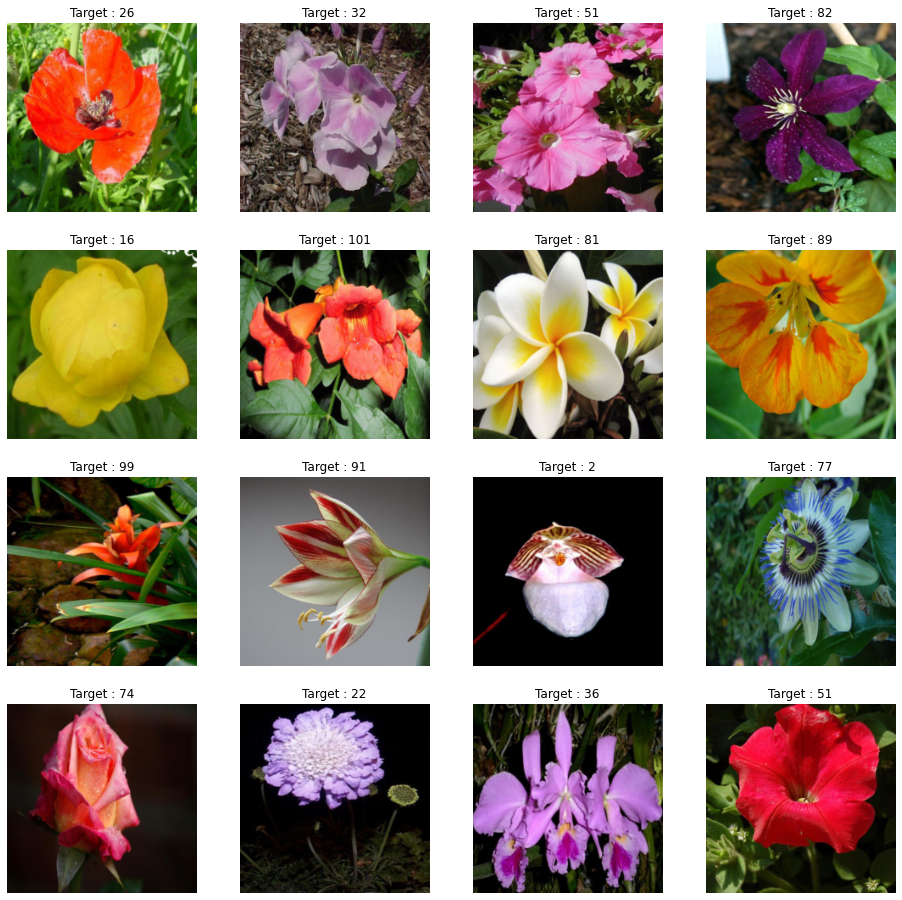

In [13]:
def plot_loader(images, labels):
    plt.subplots(8, CFG.batch_size//8 , figsize=(16, 16))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(4, CFG.batch_size//4, i+1)
        plt.axis('off')
        temp = unorm(image)
        plt.imshow( temp.permute(1, 2, 0))
        plt.title("Target : " + str(*CFG.le.inverse_transform([label.numpy()])))
    plt.show()
    
images, labels = next(iter(test_loader))
plot_loader(images, labels)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
                nn.Linear(2048, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, CFG.num_classes)
)
model.to(device)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
n_total_steps = len(train_loader)

In [ ]:

def train(model, train_loader):
    model.train()
    train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # accuracy
        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_train += (labels == predicted).sum().item()
        train_acc = (100 * correct_train) / target_count
    return train_acc, train_loss / target_count
    

In [ ]:

def validate(model,val_loader):
    model.eval()
    val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_val += (labels == predicted).sum().item()
        val_acc = (100 * correct_val) / target_count
    return val_acc, val_loss / target_count 
    

In [ ]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

# Early stopping
the_last_loss = 100
patience = 5
trigger_times = 0
isStopped = False

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

for epoch in range(0, CFG.num_epochs):
    
    train_acc, train_loss = train(model, train_loader)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    val_acc,val_loss = validate(model, test_loader)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    print("Epoch {:.6f}: train_acc {:.6f} \t train_loss {:.6f} \t val_acc {:.6f} \t val_loss {:.6f}".format(epoch, train_acc, train_loss, val_acc, val_loss))
    
    the_current_loss = val_loss
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times: ', trigger_times)
        if trigger_times >= patience:
            print('Early stopping! at epoch {0}'.format(epoch))
            isStopped = True
            break
    else:
        print('trigger times: 0')
        trigger_times = 0
        the_last_loss = the_current_loss
        if not isStopped:
            torch.save(model.state_dict(), 'flower_classification.pt')
            print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

100%|██████████| 52/52 [00:14<00:00,  3.65it/s]


Epoch 0.000000: train_acc 38.085788 	 train_loss 0.167008 	 val_acc 54.146341 	 val_loss 0.121942
trigger times: 0
Validation loss 0.121942.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.60it/s]


Epoch 1.000000: train_acc 67.409556 	 train_loss 0.074967 	 val_acc 74.634146 	 val_loss 0.059124
trigger times: 0
Validation loss 0.059124.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.63it/s]


Epoch 2.000000: train_acc 78.736071 	 train_loss 0.047662 	 val_acc 82.560976 	 val_loss 0.040773
trigger times: 0
Validation loss 0.040773.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.66it/s]


Epoch 3.000000: train_acc 83.666616 	 train_loss 0.036179 	 val_acc 85.609756 	 val_loss 0.034111
trigger times: 0
Validation loss 0.034111.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.61it/s]


Epoch 4.000000: train_acc 87.177530 	 train_loss 0.027578 	 val_acc 89.024390 	 val_loss 0.028029
trigger times: 0
Validation loss 0.028029.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.67it/s]


Epoch 5.000000: train_acc 88.734544 	 train_loss 0.025034 	 val_acc 90.121951 	 val_loss 0.023762
trigger times: 0
Validation loss 0.023762.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.70it/s]


Epoch 6.000000: train_acc 90.154175 	 train_loss 0.020376 	 val_acc 86.585366 	 val_loss 0.033991
trigger times:  1


100%|██████████| 52/52 [00:14<00:00,  3.61it/s]


Epoch 7.000000: train_acc 91.848573 	 train_loss 0.017280 	 val_acc 90.365854 	 val_loss 0.021757
trigger times: 0
Validation loss 0.021757.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.62it/s]


Epoch 8.000000: train_acc 92.840788 	 train_loss 0.015901 	 val_acc 88.170732 	 val_loss 0.028061
trigger times:  1


100%|██████████| 52/52 [00:14<00:00,  3.61it/s]


Epoch 9.000000: train_acc 92.794993 	 train_loss 0.015333 	 val_acc 89.268293 	 val_loss 0.028040
trigger times:  2


100%|██████████| 52/52 [00:14<00:00,  3.66it/s]


Epoch 10.000000: train_acc 92.978171 	 train_loss 0.015068 	 val_acc 91.829268 	 val_loss 0.022266
trigger times:  3


100%|██████████| 52/52 [00:14<00:00,  3.63it/s]


Epoch 11.000000: train_acc 93.909327 	 train_loss 0.013313 	 val_acc 92.073171 	 val_loss 0.020719
trigger times: 0
Validation loss 0.020719.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.66it/s]


Epoch 12.000000: train_acc 95.267898 	 train_loss 0.010224 	 val_acc 92.804878 	 val_loss 0.018183
trigger times: 0
Validation loss 0.018183.  Saving model ...


100%|██████████| 52/52 [00:14<00:00,  3.65it/s]


Epoch 13.000000: train_acc 94.092505 	 train_loss 0.011867 	 val_acc 88.536585 	 val_loss 0.031904
trigger times:  1


100%|██████████| 52/52 [00:14<00:00,  3.60it/s]


Epoch 14.000000: train_acc 95.237368 	 train_loss 0.010167 	 val_acc 91.341463 	 val_loss 0.022891
trigger times:  2


100%|██████████| 52/52 [00:14<00:00,  3.65it/s]


Epoch 15.000000: train_acc 95.481606 	 train_loss 0.009869 	 val_acc 91.829268 	 val_loss 0.019634
trigger times:  3


100%|██████████| 52/52 [00:14<00:00,  3.66it/s]


Epoch 16.000000: train_acc 95.222103 	 train_loss 0.010155 	 val_acc 91.585366 	 val_loss 0.025448
trigger times:  4


100%|██████████| 52/52 [00:14<00:00,  3.61it/s]

Epoch 17.000000: train_acc 95.466341 	 train_loss 0.009542 	 val_acc 92.195122 	 val_loss 0.020222
trigger times:  5
Early stopping! at epoch 17


In [ ]:
model.load_state_dict(torch.load('flower_classification.pt'))

<All keys matched successfully>

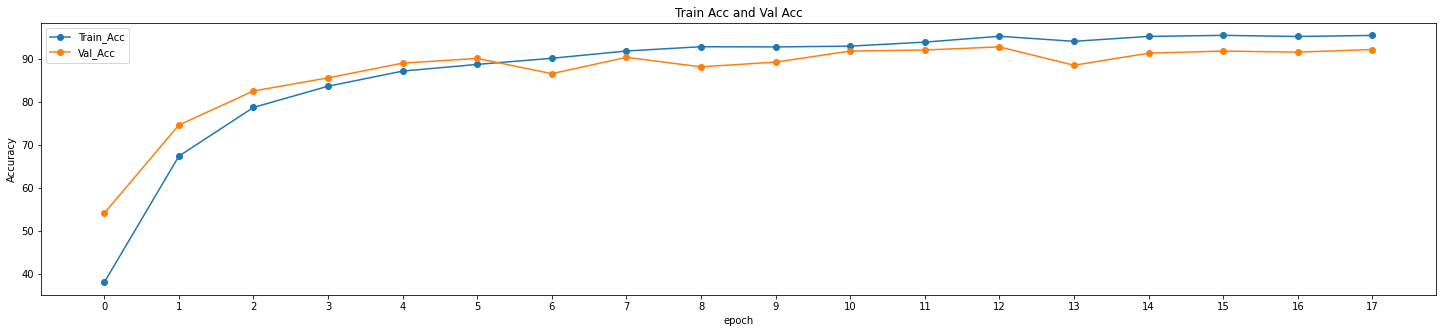

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_acc_history,'-o')
plt.plot(val_acc_history,'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Acc','Val_Acc'])
plt.title('Train Acc and Val Acc')
plt.show()

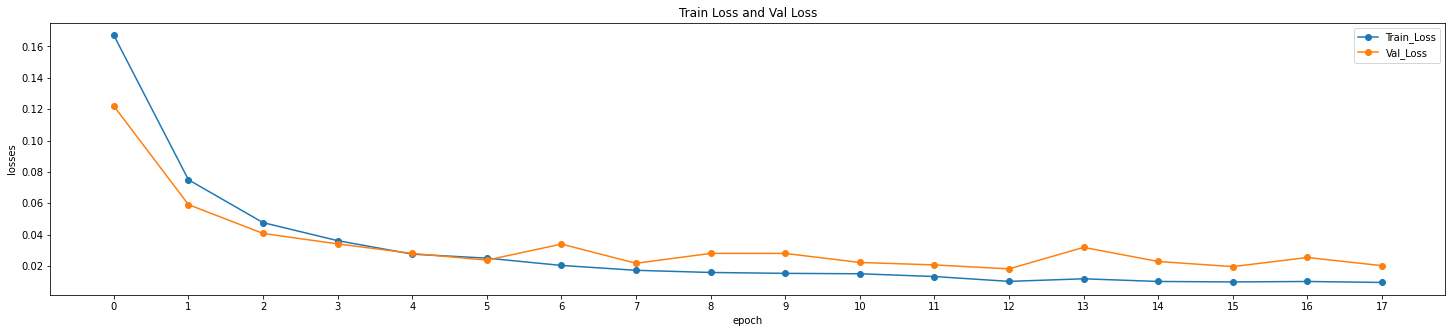

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Loss','Val_Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

In [ ]:
model.eval()
pred_list = []
label_list = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    running_loss=0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)
        pred_list.extend(predictions.cpu().numpy())
        label_list.extend(labels.cpu().numpy())
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 92.8048780487805 %


In [ ]:
import pickle

classes = os.listdir('./data_folders')
classes.sort()
# print(classes)

filename = 'classes_id'
outfile = open(filename,'wb')
pickle.dump(classes, outfile)
outfile.close()

In [ ]:
def pre_image(image_path,model):
   img = Image.open(image_path)
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   transform_norm = transforms.Compose([transforms.ToTensor(), 
   transforms.Resize((112,112)),transforms.Normalize(mean, std)])
   
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to(device)
   
   with torch.no_grad():
      model.eval()  
      output = model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      result = classes[index]
      return result

print(pre_image('./data_folders/101/image_07944.jpg', model))

101
